In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform, cdist #Euclidian distance
from sklearn.metrics.pairwise import euclidean_distances
import scipy.cluster.hierarchy as hac #dendogram
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.metrics import davies_bouldin_score
from sklearn.mixture import GaussianMixture #For GMM clustering

In [124]:
#dunn index project taken from github user "keizerilla"

def normalize_to_smallest_integers(labels):
    """Normalizes a list of integers so that each number is reduced to the minimum possible integer, maintaining the order of elements.
    :param labels: the list to be normalized
    :returns: a numpy.array with the values normalized as the minimum integers between 0 and the maximum possible value.
    """

    max_v = len(set(labels)) if -1 not in labels else len(set(labels)) - 1
    sorted_labels = np.sort(np.unique(labels))
    unique_labels = range(max_v)
    new_c = np.zeros(len(labels), dtype=np.int32)

    for i, clust in enumerate(sorted_labels):
        new_c[labels == clust] = unique_labels[i]

    return new_c


def dunn(labels, distances):
    """
    Dunn index for cluster validation (the bigger, the better)
    
    .. math:: D = \\min_{i = 1 \\ldots n_c; j = i + 1\ldots n_c} \\left\\lbrace \\frac{d \\left( c_i,c_j \\right)}{\\max_{k = 1 \\ldots n_c} \\left(diam \\left(c_k \\right) \\right)} \\right\\rbrace
    
    where :math:`d(c_i,c_j)` represents the distance between
    clusters :math:`c_i` and :math:`c_j`, given by the distances between its
    two closest data points, and :math:`diam(c_k)` is the diameter of cluster
    :math:`c_k`, given by the distance between its two farthest data points.
    
    The bigger the value of the resulting Dunn index, the better the clustering
    result is considered, since higher values indicate that clusters are
    compact (small :math:`diam(c_k)`) and far apart.
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    
    .. [Kovacs2005] Kovács, F., Legány, C., & Babos, A. (2005). Cluster validity measurement techniques. 6th International Symposium of Hungarian Researchers on Computational Intelligence.
    """

    labels = normalize_to_smallest_integers(labels)

    unique_cluster_distances = np.unique(distances)
    min_cluster_distances(labels, distances)
    max_diameter = max(diameter(labels, distances))

    if np.size(unique_cluster_distances) > 1:
        return unique_cluster_distances[1] / max_diameter
    else:
        return unique_cluster_distances[0] / max_diameter


def min_cluster_distances(labels, distances):
    """Calculates the distances between the two nearest points of each cluster.
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    """
    labels = normalize_to_smallest_integers(labels)
    n_unique_labels = len(np.unique(labels))

    min_distances = np.zeros((n_unique_labels, n_unique_labels))
    for i in np.arange(0, len(labels) - 1):
        for ii in np.arange(i + 1, len(labels)):
            if labels[i] != labels[ii] and distances[i, ii] < min_distances[labels[i], labels[ii]]:
                min_distances[labels[i], labels[ii]] = min_distances[labels[ii], labels[i]] = distances[i, ii]
    return min_distances


def diameter(labels, distances):
    """Calculates cluster diameters (the distance between the two farthest data points in a cluster)
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :returns:
    """
    labels = normalize_to_smallest_integers(labels)
    n_clusters = len(np.unique(labels))
    diameters = np.zeros(n_clusters)

    for i in np.arange(0, len(labels) - 1):
        for ii in np.arange(i + 1, len(labels)):
            if labels[i] == labels[ii] and distances[i, ii] > diameters[labels[i]]:
                diameters[labels[i]] = distances[i, ii]
    return diameters


In [4]:
#read stats data
stats = pd.read_csv('Seasons_Stats.csv')
stats.shape

(24691, 53)

In [5]:
sum(stats.Tm.isnull())
stats.dropna(subset = ['Tm'], inplace = True)

In [6]:
df_stats_1718 = stats.loc[(stats.Year == 2017.0) | (stats.Year == 2018.0)]

In [7]:
#read salary data
df_salaries = pd.read_csv('NBA_season1718_salary.csv')
df_salaries.head()

,Unnamed: 0,Player,Tm,season17_18
0,1,Stephen Curry,GSW,34682550.0
1,2,LeBron James,CLE,33285709.0
2,3,Paul Millsap,DEN,31269231.0
3,4,Gordon Hayward,BOS,29727900.0
4,5,Blake Griffin,DET,29512900.0


In [8]:
#merge the tables into one on Player name
df_players = df_stats_1718.merge(df_salaries, on = 'Player')

In [9]:
#drop duplicate players keeping their highest earned salary that year
df_players.drop_duplicates(subset = 'Player', inplace = True)

In [10]:
#clean the data and drop columns we don't need
df_players.columns

Index(['Unnamed: 0_x', 'Year', 'Player', 'Pos', 'Age', 'Tm_x', 'G', 'GS', 'MP',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'blanl', 'OWS', 'DWS', 'WS', 'WS/48', 'blank2',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Unnamed: 0_y', 'Tm_y',
       'season17_18'],
      dtype='object')

In [11]:
#drop unnused columns
df_players.drop(columns=['Unnamed: 0_x','Unnamed: 0_y', 'blanl','blank2','Tm_x','Age','Pos','Tm_y'], inplace = True)

In [12]:
#reset salary column to be in millions
df_players.rename(columns={'season17_18': 'Salary_17_18'}, inplace = True)

In [13]:
#change salary to millions
df_players['Salary_17_18'] = (df_players['Salary_17_18']/1000000).round(3)

In [14]:
df_players.columns

Index(['Year', 'Player', 'G', 'GS', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%',
       'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS',
       'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Salary_17_18'],
      dtype='object')

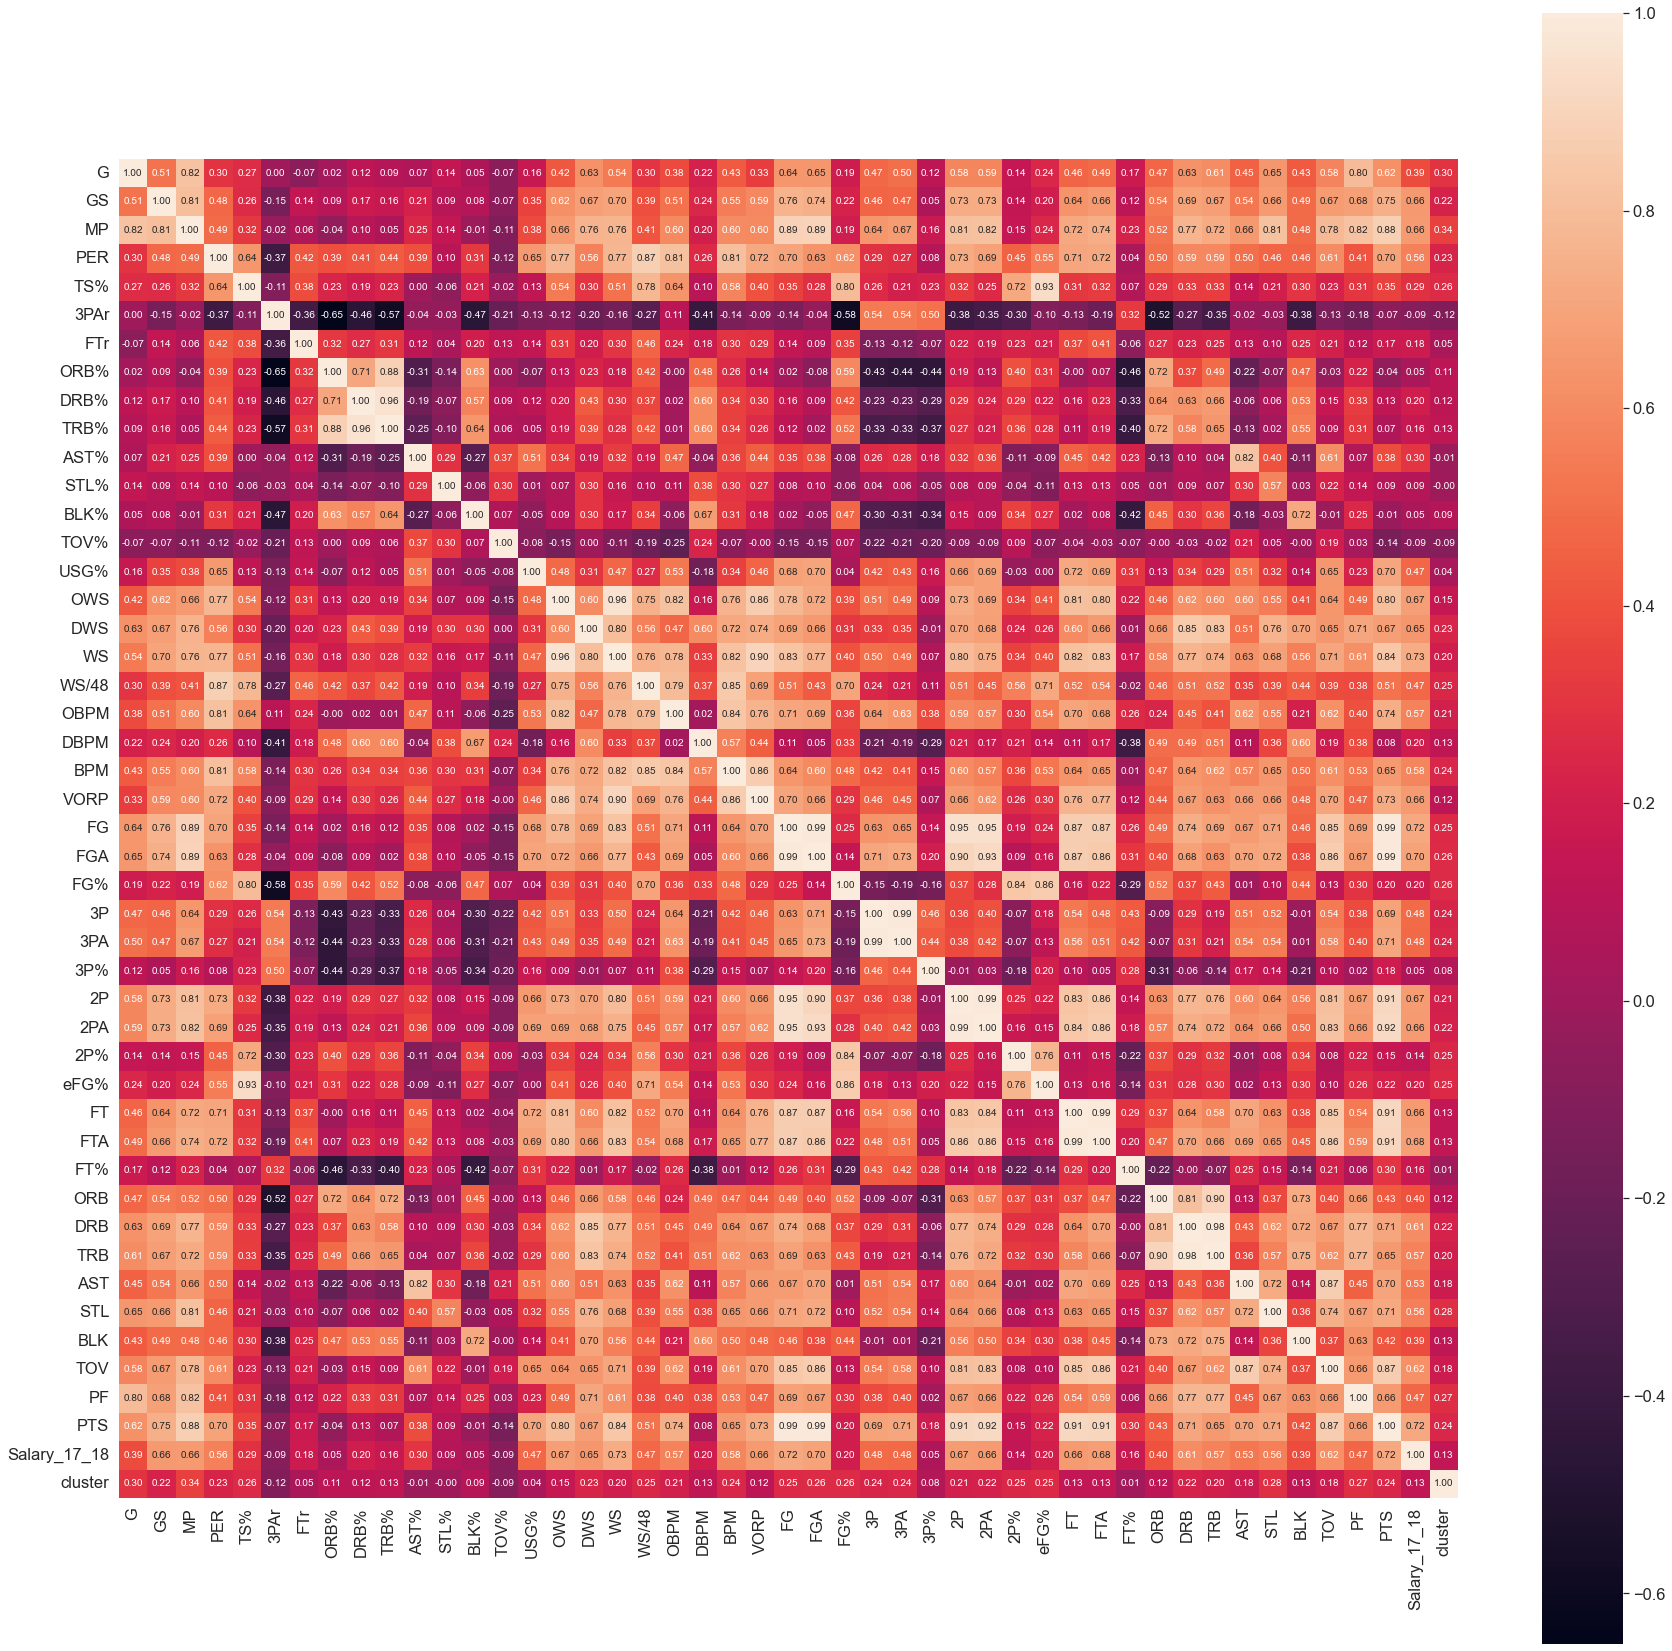

In [68]:
#correlation matrix

#all columns from GP (games played) and on
int_cols = df_players.columns.values[2:]

#correlation
sns.set(style="white")
plt.figure(figsize=(30,30))
cm = np.corrcoef(df_players[int_cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=int_cols, xticklabels=int_cols)
plt.show()

In [16]:
df_players.dropna(inplace = True)

In [17]:
#normalize the data excluding salary because we will use salary later to find more 'valueable' players
norm_df = normalize(df_players[['G', 'GS', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%',
       'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS',
       'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']],axis=1, copy=True, return_norm=False)

In [18]:
#find euclidian distance to find close players
player_dist = pdist(norm_df, 'euclidean')
dist_df = pd.DataFrame(squareform(player_dist))
dist_df.set_index(df_players['Player'],inplace = True)
dist_df.columns = list(dist_df.index)
dist_df.shape

(381, 381)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


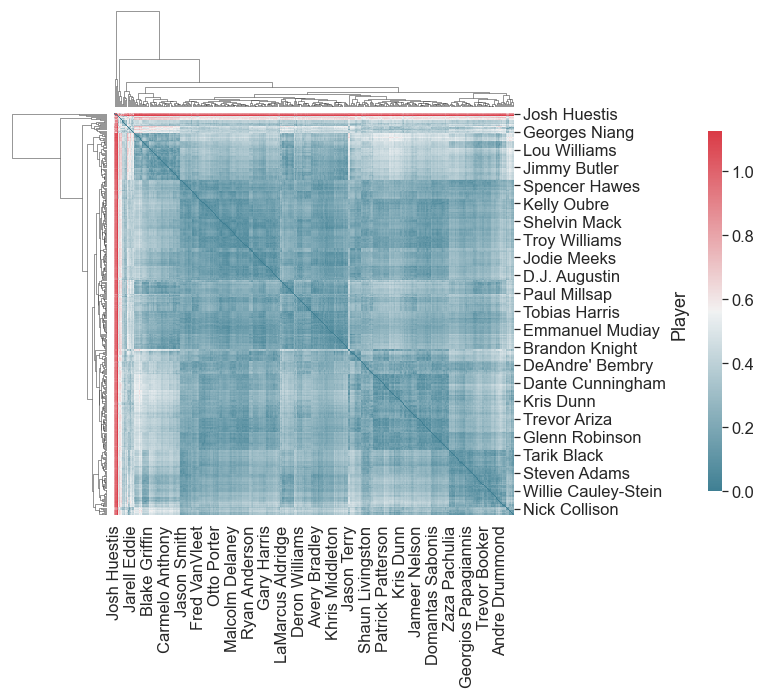

In [19]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.clustermap(dist_df,cmap=cmap,cbar_pos=(1, .3, .02, .5))
plt.show()

In [20]:
top_players = []
for i,x in df_players.sort_values(by = 'PER', ascending = False)[1:10].iterrows():
    top_players.append(df_players.Player[i])

In [21]:
#closest euclidean player
closest = np.where(dist_df.eq(dist_df[dist_df != 0].min(),0),dist_df.columns,False)
# Remove false from the array and get the column names as list
closest_player_df = pd.DataFrame()
closest_player_df["PLAYER"] = df_players["Player"]
closest_player_df['CLOSEST_PLAYER'] = [i[i.astype(bool)].tolist() for i in closest]
closest_top = closest_player_df[closest_player_df['PLAYER'].isin(top_players)]
closest_top

,PLAYER,CLOSEST_PLAYER
120,Anthony Davis,[Enes Kanter]
139,Kevin Durant,[LeBron James]
201,James Harden,[Damian Lillard]
253,LeBron James,[Kevin Durant]
269,Nikola Jokic,[Karl-Anthony Towns]
296,Kawhi Leonard,[Damian Lillard]
396,Chris Paul,[Jeremy Lin]
474,Isaiah Thomas,[Damian Lillard]
518,Russell Westbrook,[DeMarcus Cousins]


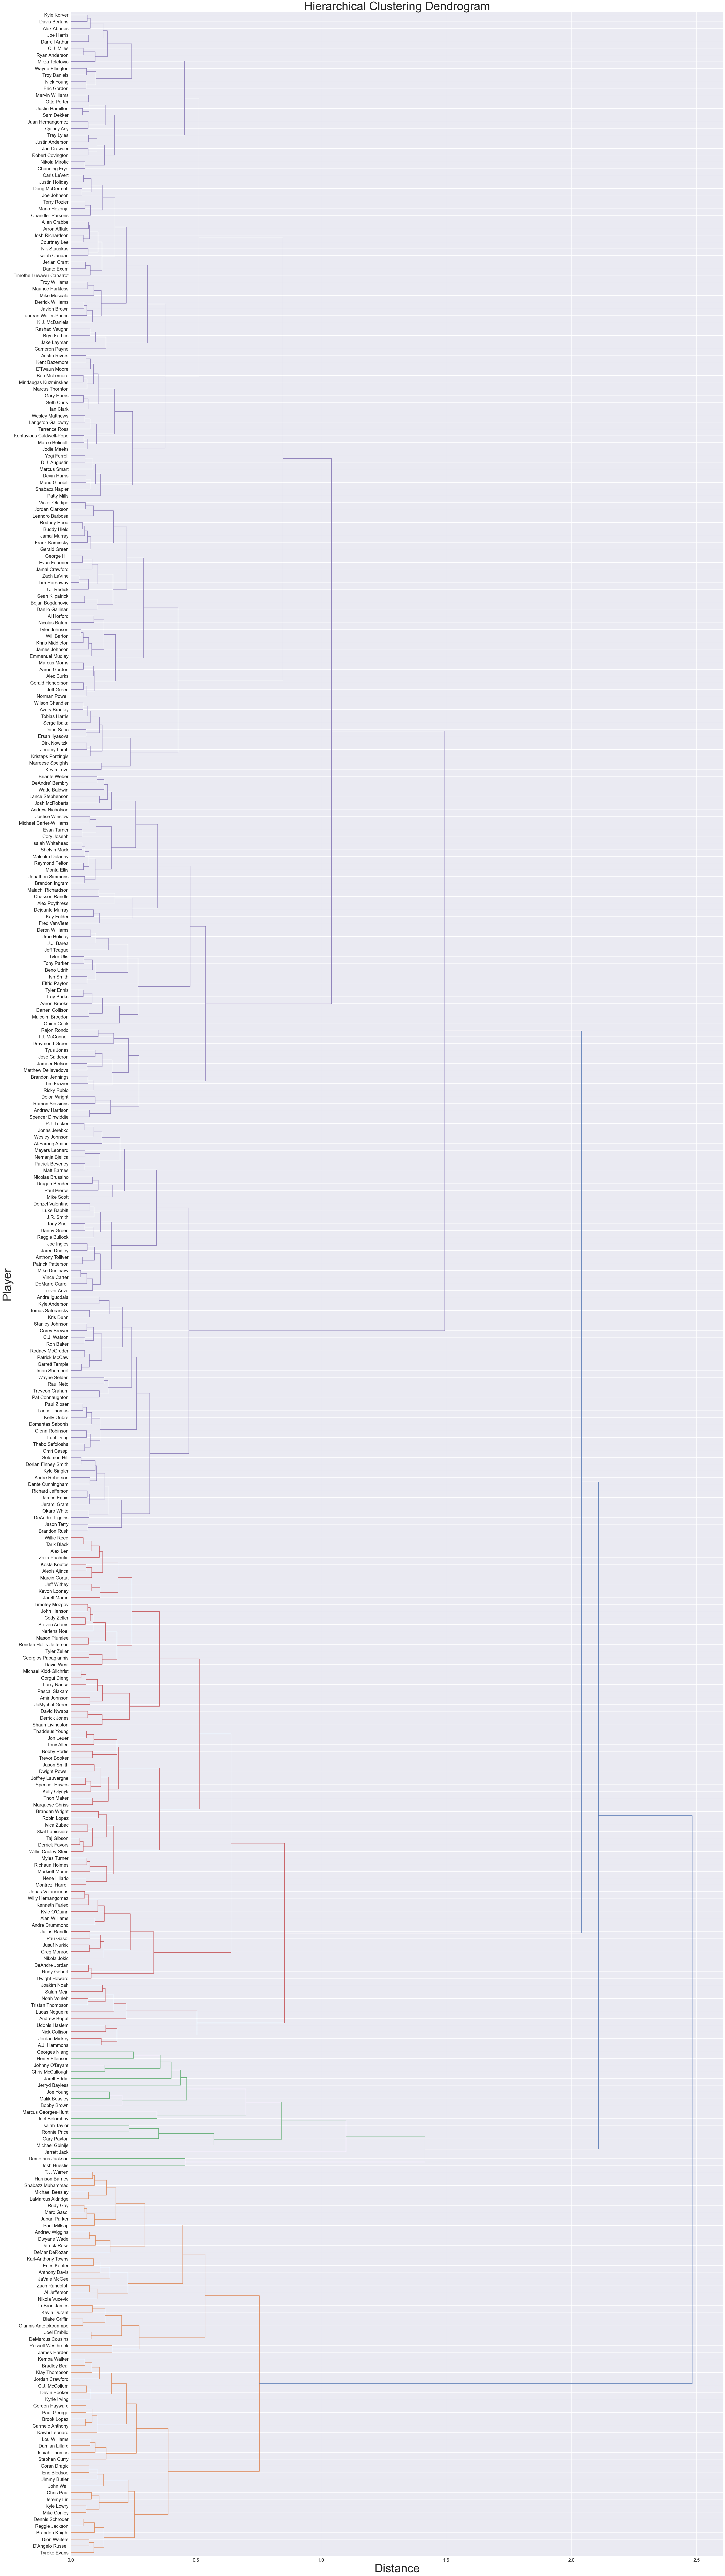

In [22]:
#Hierarchal Dendogram

cluster_hac = hac.linkage(norm_df,method="ward")
plt.figure(figsize=(50, 200))
dendogram = hac.dendrogram(cluster_hac, leaf_font_size=50,orientation='right',show_leaf_counts = True,show_contracted=True,labels=dist_df.index)
plt.title('Hierarchical Clustering Dendrogram', fontsize=50)
plt.xlabel('Distance', fontsize=50)
plt.ylabel('Player', fontsize=50)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [23]:
#drop columns we don't want normalized
df_players_stats_no_sal = df_players.drop(columns = ['Year','Player','Salary_17_18'])

In [24]:
normalized_stats =(df_players_stats_no_sal-df_players_stats_no_sal.mean())/df_players_stats_no_sal.std()

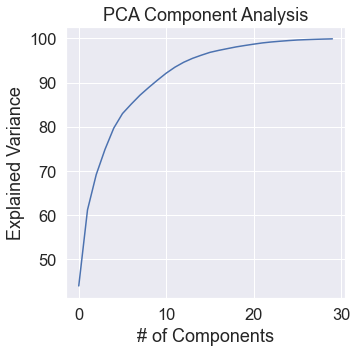

In [25]:
#PCA

pca = PCA(n_components = 30)
pca = pca.fit(normalized_stats)
var = pca.explained_variance_ratio_
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals = 4)*100)
plt.figure(figsize = (5,5))
plt.plot(var1)
plt.xlabel('# of Components')
plt.ylabel('Explained Variance')
plt.title('PCA Component Analysis')
plt.show()

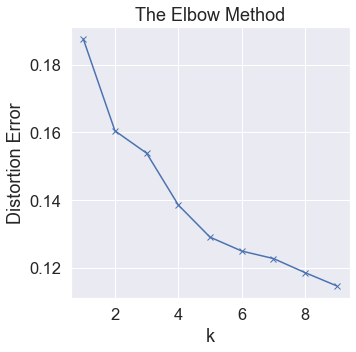

In [26]:
#elbow method to ID # of clusters for KMeans
distortions = []
for k in range(1,10):
    kmeanModel = KMeans(n_clusters=k).fit(normalized_stats)
    kmeanModel.fit(norm_df)
    distortions.append(sum(np.min(cdist(norm_df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / dist_df.shape[0])

# Plot the elbow
plt.figure(figsize = (5,5))
plt.plot(range(1,10), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion Error')
plt.title('The Elbow Method')
plt.show()

In [142]:
#silhouette score method
pca_df = PCA(n_components = 2, whiten = True).fit_transform(normalized_stats)
k_range = range(2,15)
k_means_var = [KMeans(n_clusters = k).fit(pca_df) for k in k_range]
gmm_var = [GaussianMixture(n_components=k,init_params='kmeans').fit(pca_df) for k in k_range]
agg_var = [AgglomerativeClustering(n_clusters=k, affinity = 'euclidean', linkage = 'ward').fit(pca_df) for k in k_range]
k_labels = [i.labels_ for i in k_means_var]
g_labels = [j.predict(pca_df) for j in gmm_var]
a_labels = [k.fit_predict(pca_df) for k in agg_var]
km_s_score = [metrics.silhouette_score(pca_df, i , metric = 'euclidean') for i in k_labels]
gmm_s_score = [metrics.silhouette_score(pca_df, j , metric = 'euclidean') for j in g_labels]
agg_s_score = [metrics.silhouette_score(pca_df, k , metric = 'euclidean') for k in a_labels]

k_centroids = [i.cluster_centers_ for i in k_means_var]
k_euclid = [cdist(pca_df,cent,'euclidean') for cent in centroids]
dist = [np.min(k,axis = 1) for k in k_euclid]
wcss = [sum(d**2) for d in dist]
tss = sum(pdist(pca_df)**2/pca_df.shape[0])
bss = tss - wcss

Text(0, 0.5, 'Silhouette Score')

<Figure size 720x720 with 0 Axes>

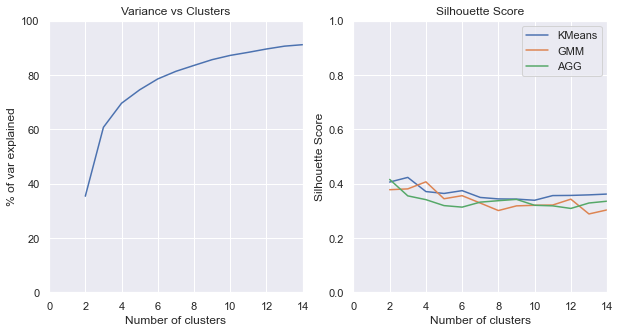

In [146]:
plt.clf()
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.title('Variance vs Clusters')
plt.plot(k_range, bss/tss*100)
plt.axis([0, np.max(k_range), 0 ,100])
plt.xlabel('Number of clusters')
plt.ylabel('% of var explained')

plt.subplot(1,2,2)
plt.plot(k_range, km_s_score, label = 'KMeans')
plt.plot(k_range, gmm_s_score, label = 'GMM')
plt.plot(k_range, agg_s_score, label = 'AGG')
plt.legend()
plt.axis([0, np.max(k_range), 0, 1])
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

In [29]:
fit_clusters = KMeans(n_clusters = 6, random_state = 1).fit(pca_df)
df_players['cluster'] = fit_clusters.labels_

In [30]:
dunn_norm_df = normalize(df_players[['G', 'GS', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%',
       'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS',
       'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']],axis=1, copy=True, return_norm=False)
dunn_dist = pdist(normalized_stats, 'euclidean')
dunn_dist = pd.DataFrame(squareform(dunn_dist))
dunn_dist.set_index(df_players['Player'],inplace = True)
dunn_dist.columns = list(dunn_dist.index)
np_dunn_dist = dunn_dist.to_numpy()
labels = list(df_players.cluster.copy())
dunn_index= dunn(labels, np_dunn_dist)
print("Dunn Index: ", dunn_index)

Dunn Index:  0.09402627944684272


In [31]:
df_players.cluster.value_counts()

0    117
4    106
5     54
3     40
1     34
2     30
Name: cluster, dtype: int64

In [32]:
#We decided to drop the players that played less than a quarter of the season (20 games)
df_players[df_players.G < 20]

,Year,Player,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Salary_17_18,cluster
35,2017.0,Jerryd Bayless,3.0,1.0,71.0,8.7,0.453,0.156,0.313,4.6,...,9.0,12.0,13.0,0.0,0.0,9.0,4.0,33.0,9.000,0
57,2017.0,Joel Bolomboy,12.0,0.0,53.0,19.7,0.590,0.250,0.375,9.0,...,13.0,17.0,2.0,1.0,2.0,2.0,1.0,22.0,1.313,5
101,2017.0,Quinn Cook,14.0,0.0,188.0,11.8,0.579,0.394,0.076,0.6,...,6.0,7.0,26.0,4.0,0.0,13.0,13.0,79.0,0.100,0
114,2017.0,Jordan Crawford,19.0,0.0,442.0,17.6,0.582,0.436,0.119,0.9,...,30.0,34.0,57.0,11.0,2.0,25.0,30.0,267.0,0.250,0
140,2017.0,Jarell Eddie,5.0,0.0,62.0,9.7,0.523,0.842,0.474,1.7,...,6.0,7.0,0.0,1.0,0.0,1.0,1.0,24.0,0.083,0
143,2017.0,Henry Ellenson,19.0,2.0,146.0,7.5,0.444,0.547,0.125,5.8,...,33.0,41.0,7.0,1.0,1.0,14.0,6.0,60.0,1.781,0
176,2017.0,Michael Gbinije,9.0,0.0,32.0,-2.1,0.184,0.400,0.200,6.6,...,1.0,3.0,2.0,0.0,0.0,0.0,2.0,4.0,0.500,0
178,2017.0,Marcus Georges-Hunt,5.0,0.0,48.0,10.2,0.614,0.286,1.429,2.2,...,8.0,9.0,3.0,1.0,0.0,2.0,5.0,14.0,1.313,0
209,2017.0,Udonis Haslem,17.0,0.0,130.0,8.4,0.524,0.130,0.652,6.7,...,28.0,36.0,6.0,5.0,1.0,8.0,22.0,31.0,2.329,5
232,2017.0,Josh Huestis,2.0,0.0,31.0,26.1,0.612,0.364,0.091,14.3,...,5.0,9.0,3.0,0.0,3.0,0.0,0.0,14.0,1.471,1


In [33]:
#take the players with at least 20 games and redo the process of pca
df_full_season = df_players[df_players.G >= 20]
df_players_stats_no_sal2 = df_full_season.drop(columns = ['Year','Player','cluster'])
normalized_stats2 =(df_players_stats_no_sal2-df_players_stats_no_sal2.mean())/df_players_stats_no_sal2.std()

In [34]:
df_full_season.shape

(359, 49)

In [35]:
df_full_seaons_pca = PCA(n_components = 2, whiten = True).fit_transform(normalized_stats2)
PCA_df = pd.DataFrame(data = df_full_seaons_pca, columns = ['PCA1', 'PCA2'] )
PCA_df = pd.concat([df_full_season['Player'],PCA_df], axis=1)

In [36]:
fit_clusters = KMeans(n_clusters = 6, random_state = 1).fit(df_full_seaons_pca)
df_full_season['cluster'] = fit_clusters.labels_
df_full_season.cluster.value_counts()

/var/folders/0p/zqq8jb453_7c4r949g3mt79r0000gp/T/ipykernel_43735/1888547008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_season['cluster'] = fit_clusters.labels_


4    125
0     85
1     56
3     46
5     30
2     17
Name: cluster, dtype: int64

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


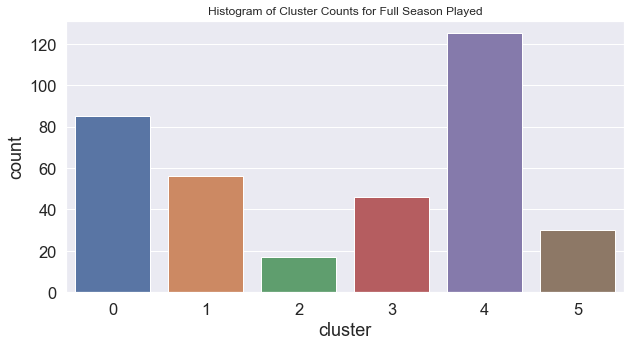

In [37]:
ax=plt.subplots(figsize=(10,5))
ax=sns.countplot(df_full_season.cluster)
title="Histogram of Cluster Counts for Full Season Played"
ax.set_title(title, fontsize=12)
plt.show()

In [38]:
stats_only = df_full_season[['G', 'GS', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%',
       'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS',
       'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Salary_17_18',
       'cluster']].copy()

In [39]:
stats_only.columns

Index(['G', 'GS', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%',
       'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Salary_17_18', 'cluster'],
      dtype='object')

In [ ]:
output = pd.DataFrame({'cluster':[i for i in range(fit_clusters.n_clusters)]})
for column in stats_only.columns:
    if(column == 'cluster'):
        continue
    lst = []
    for i in range(fit_clusters.n_clusters):
        mean = stats_only[stats_only['cluster'] == i].describe()[column]['mean']
        lst.append([i, round(mean,2)])
    df = pd.DataFrame(lst)
    df.columns = ['cluster', column]
    output = pd.merge(output, df, on='cluster', how='outer')

In [ ]:
output.sort_values(by = 'Salary_17_18', ascending = False)

,cluster,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Salary_17_18
5,5,75.20,72.43,2580.23,22.13,0.58,0.34,0.35,2.75,13.54,...,64.20,317.27,381.47,425.23,94.93,29.03,213.97,163.00,1741.60,20.61
2,2,78.65,66.65,2358.71,21.22,0.60,0.05,0.42,11.23,26.22,...,232.71,557.94,790.65,161.71,69.41,100.71,143.41,209.24,1174.00,16.49
3,3,72.78,54.09,2112.15,16.28,0.55,0.30,0.26,5.46,18.45,...,103.15,345.28,448.43,175.11,68.78,52.26,109.61,175.89,978.15,12.66
0,0,69.89,37.52,1850.45,13.00,0.54,0.44,0.21,1.99,10.72,...,33.85,178.46,212.31,197.42,59.48,17.34,96.07,129.66,764.89,8.53
1,1,57.64,23.34,1062.11,15.56,0.57,0.07,0.31,9.44,20.21,...,90.41,192.11,282.52,56.57,32.82,43.84,53.27,120.75,403.27,5.24
4,4,54.33,10.84,930.31,10.22,0.51,0.41,0.20,3.02,12.99,...,26.20,111.23,137.43,70.97,28.78,12.63,43.36,79.98,310.16,3.34


Text(0.5, 1.0, 'Stats per Game by Cluster')

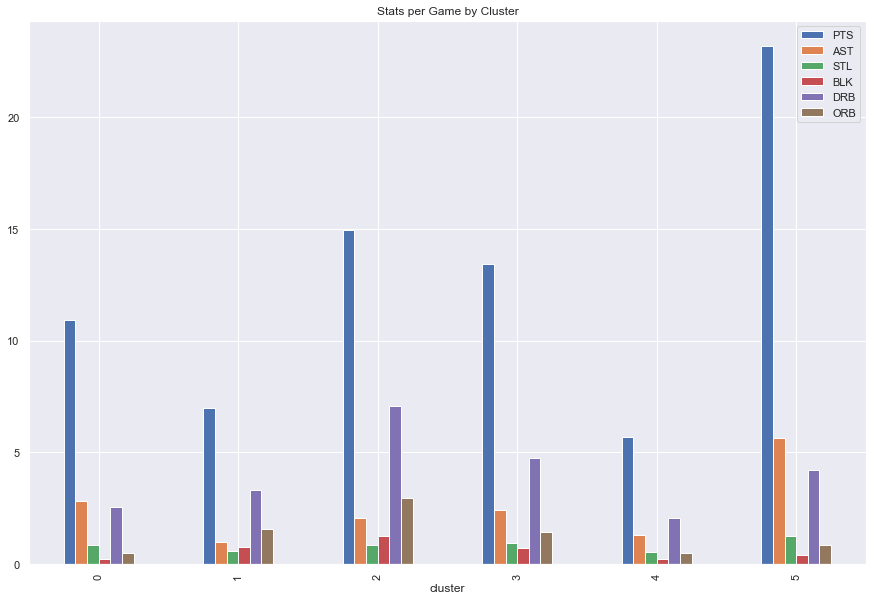

In [155]:
output_plot = output[['PTS', 'AST', 'STL', 'BLK', 'DRB', 'ORB', 'cluster']]
output_plot.groupby("cluster").aggregate("mean").plot.bar(figsize=(15,10))
plt.title("Stats per Game by Cluster")


In [43]:
analysis_df = df_full_season[['Player', 'Salary_17_18']] # Vary the element of interest here
temp = pd.merge(PCA_df, analysis_df, how='left', on='Player')
kmeans_results = pd.concat([temp, pd.DataFrame(data=df_full_season, columns=['cluster'])], axis=1)
kmeans_results.dropna(inplace = True)
kmeans_results

,Player,PCA1,PCA2,Salary_17_18,cluster
0,Alex Abrines,-0.771146,-0.900943,5.725,0.0
1,Quincy Acy,-0.967893,0.179627,1.710,4.0
4,Steven Adams,-0.807280,1.502627,22.472,2.0
5,Arron Afflalo,1.220368,0.588653,2.329,4.0
7,Alexis Ajinca,-0.163293,0.363575,4.962,1.0
...,...,...,...,...,...
354,Timofey Mozgov,0.618858,0.620294,15.280,1.0
355,Emmanuel Mudiay,0.637970,1.653878,3.381,0.0
356,Shabazz Muhammad,-0.871617,1.377401,1.577,4.0
357,Dejounte Murray,-1.123126,-0.033092,1.313,4.0


In [44]:
#agglomeritave clustersing visuals
agg = AgglomerativeClustering(n_clusters=6, affinity = 'euclidean', linkage = 'ward').fit_predict(normalized_stats2)
agg_df = pd.DataFrame(agg)
df_full_season.insert((df_full_season.shape[1]),'AgglomerativeClustering',agg_df)

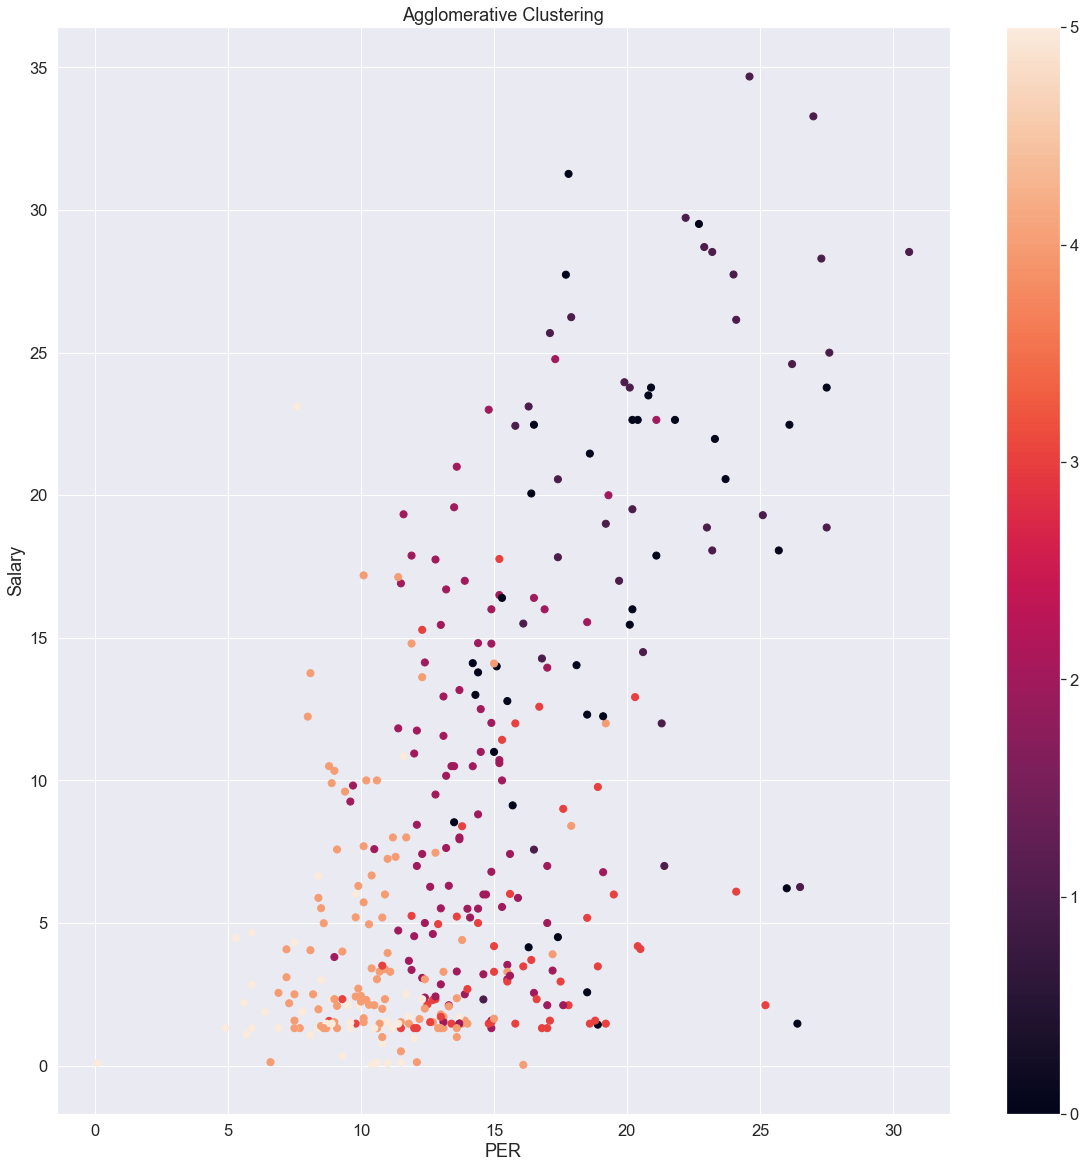

In [45]:
plt.figure(figsize=(20, 20))
scatter = plt.scatter(df_full_season['PER'],df_full_season["Salary_17_18"],
                     c=agg_df[0],s=50)
plt.title('Agglomerative Clustering')
plt.xlabel('PER')
plt.ylabel('Salary')
plt.colorbar()

In [133]:
#agglo analysis
norm_stats2_dist = pdist(normalized_stats2, 'euclidean')
dist_df = pd.DataFrame(squareform(norm_stats2_dist))
dist_df.set_index(df_full_season['Player'],inplace = True)
dist_df.columns = list(dist_df.index)


In [56]:
#Gaussian Mixture Model

gmm = GaussianMixture(n_components=6,init_params='kmeans')
gmm.fit(normalized_stats2)
gmm_label = gmm.predict(normalized_stats2)
gmm_df = pd.DataFrame(gmm_label)
df_full_season.insert((df_full_season.shape[1]),'gmm_cluster',gmm_df)

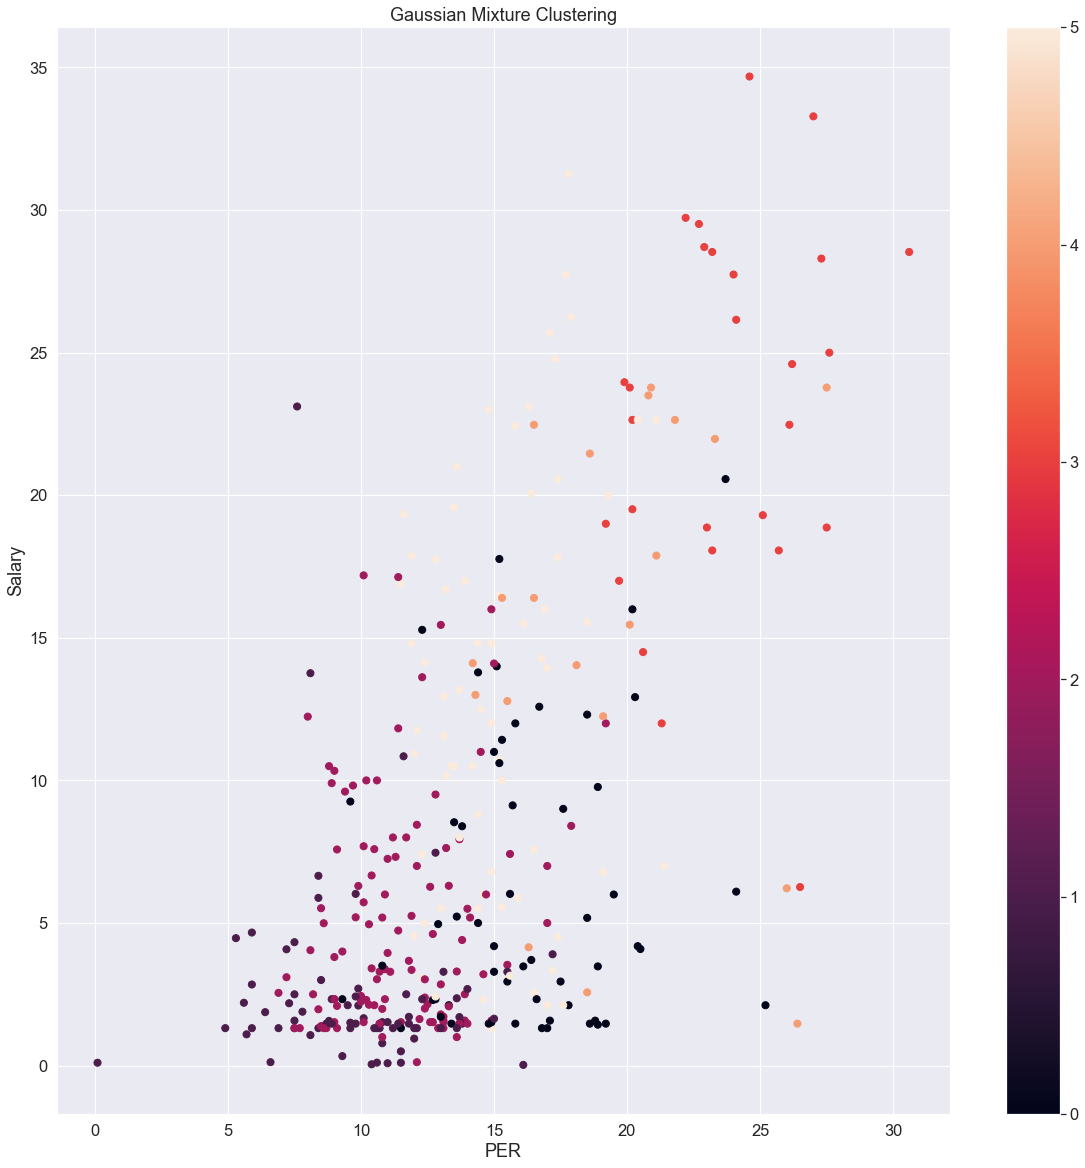

In [87]:
plt.figure(figsize=(20, 20))
scatter = plt.scatter(df_full_season['PER'],df_full_season['Salary_17_18'],
                     c=gmm_df[0],s=50)
plt.title('Gaussian Mixture Clustering')
plt.xlabel('PER')
plt.ylabel('Salary')
plt.colorbar()
#plt.text(3+0.2, 4.5, "An annotation", horizontalalignment='left', size='medium', color='black', weight='semibold')



In [150]:
#agg s score DB and DI
agg_s_score = metrics.silhouette_score(df_full_seaons_pca, agg_df, metric='euclidean')
agg_di = dunn(agg, squareform(norm_stats2_dist))
agg_db_score = davies_bouldin_score(normalized_stats2, agg_df)
print(agg_s_score, agg_db_score, agg_di)

0.24666254198763982 1.7747685882820896 0.10805740600569548


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [151]:
#GMM S score and DI and DB
gmm_s_score = metrics.silhouette_score(df_full_seaons_pca, gmm_label, metric='euclidean')
gmm_di = dunn(gmm_label, squareform(norm_stats2_dist))
gmm_db_score = davies_bouldin_score(normalized_stats2, gmm_label)
print(gmm_s_score, gmm_db_score, gmm_di)

0.280836332747554 1.6595094647926698 0.1256102880833106


In [152]:
#kmeans s score DB and DI
kmeans_s_score = metrics.silhouette_score(df_full_seaons_pca, fit_clusters.labels_, metric='euclidean')
km_di = dunn(fit_clusters.labels_, squareform(norm_stats2_dist))
km_db_score = davies_bouldin_score(normalized_stats2, fit_clusters.labels_)
print(kmeans_s_score, km_db_score, km_di)


0.37126152831569276 1.694804437441207 0.11119143017736034


In [90]:
#analysis

output[['cluster','PER','PTS','AST','STL','BLK','ORB','DRB','Salary_17_18']]

,cluster,PER,PTS,AST,STL,BLK,ORB,DRB,Salary_17_18
0,0,0.19,10.94,2.82,0.85,0.25,0.48,2.55,0.12
1,1,0.27,7.00,0.98,0.57,0.76,1.57,3.33,0.09
2,2,0.27,14.93,2.06,0.88,1.28,2.96,7.09,0.21
3,3,0.22,13.44,2.41,0.95,0.72,1.42,4.74,0.17
4,4,0.19,5.71,1.31,0.53,0.23,0.48,2.05,0.06
5,5,0.29,23.16,5.65,1.26,0.39,0.85,4.22,0.27


In [91]:
analysis_df = df_full_season[['Player', 'Salary_17_18']] # Vary the element of interest here
temp = pd.merge(PCA_df, analysis_df, how='left', on='Player')
kmeans_results = pd.concat([temp, pd.DataFrame(data=df_full_season, columns=['cluster'])], axis=1)
kmeans_results.dropna(inplace = True)
kmeans_results

,Player,PCA1,PCA2,Salary_17_18,cluster
0,Alex Abrines,-0.771146,-0.900943,5.725,0.0
1,Quincy Acy,-0.967893,0.179627,1.710,4.0
4,Steven Adams,-0.807280,1.502627,22.472,2.0
5,Arron Afflalo,1.220368,0.588653,2.329,4.0
7,Alexis Ajinca,-0.163293,0.363575,4.962,1.0
...,...,...,...,...,...
354,Timofey Mozgov,0.618858,0.620294,15.280,1.0
355,Emmanuel Mudiay,0.637970,1.653878,3.381,0.0
356,Shabazz Muhammad,-0.871617,1.377401,1.577,4.0
357,Dejounte Murray,-1.123126,-0.033092,1.313,4.0


[Text(0.5, 1.0, 'Clusters against PCA')]

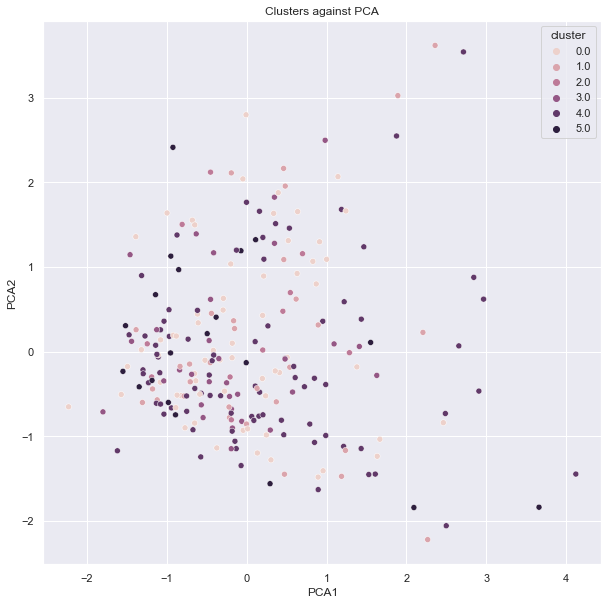

In [92]:
sns.set(rc={'figure.figsize':(10,10)})
sns.scatterplot(x="PCA1",y="PCA2",hue="cluster",
                data=kmeans_results).set(title='Clusters against PCA')

In [93]:
top_5_salary = df_full_season.sort_values(by = 'Salary_17_18', ascending = False)

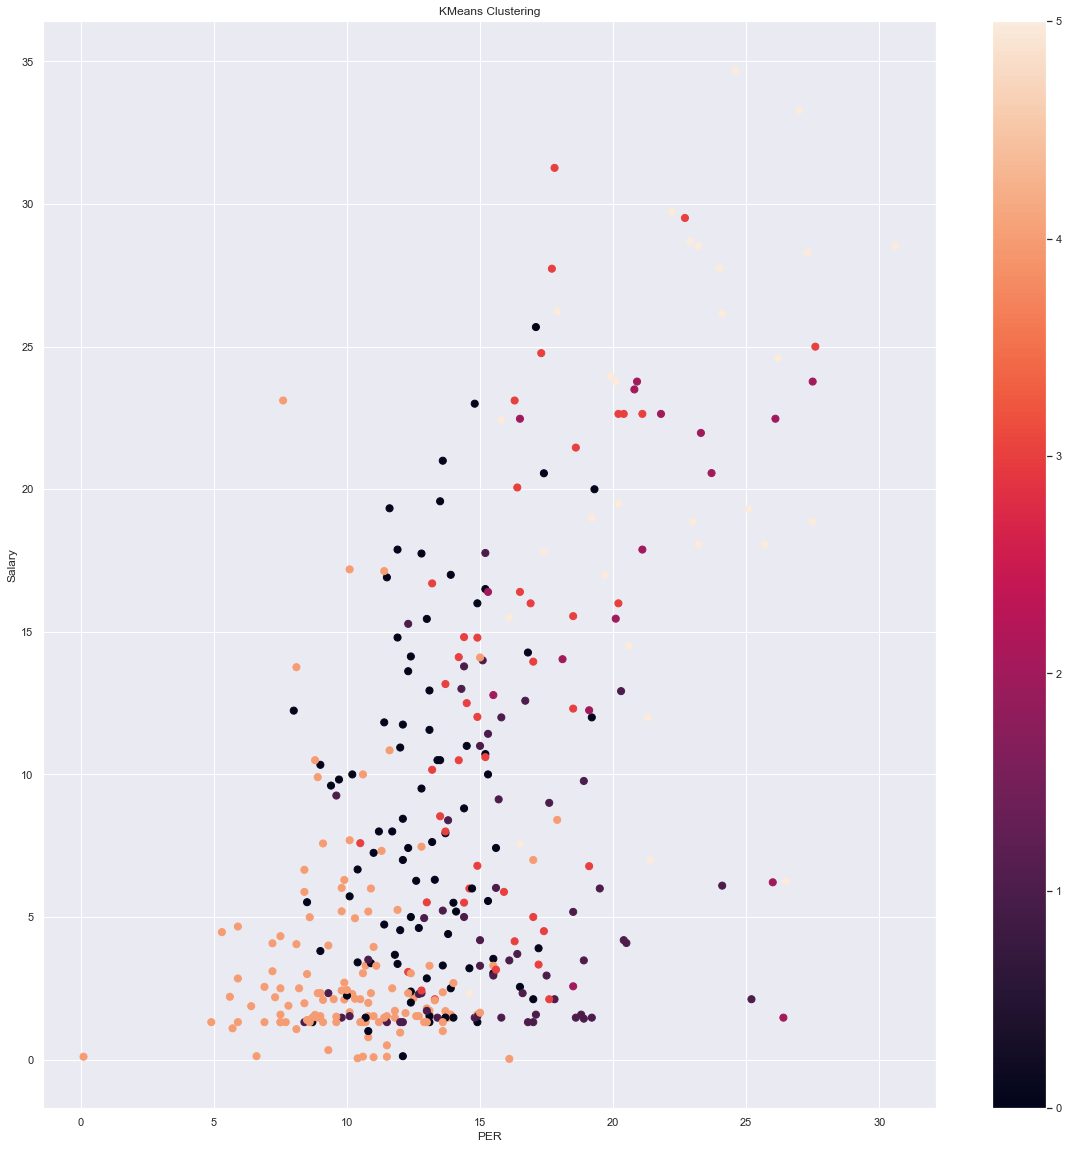

In [94]:
plt.figure(figsize=(20, 20))
scatter = plt.scatter(x = df_full_season['PER'],y = df_full_season['Salary_17_18'],
                     c=df_full_season['cluster'],s=50)
plt.title('KMeans Clustering')
plt.xlabel('PER')
plt.ylabel('Salary')
plt.colorbar()


In [177]:
output[['cluster','G','MP','PER','PTS','AST','eFG%','2PA','3P%','DRB','Salary_17_18']].sort_values(by = 'Salary_17_18', ascending = False)

,cluster,G,MP,PER,PTS,AST,eFG%,2PA,3P%,DRB,Salary_17_18
5,5,75.20,2580.23,22.13,1741.60,425.23,0.52,870.93,0.37,317.27,20.61
2,2,78.65,2358.71,21.22,1174.00,161.71,0.57,783.06,0.17,557.94,16.49
3,3,72.78,2112.15,16.28,978.15,175.11,0.52,565.85,0.35,345.28,12.66
0,0,69.89,1850.45,13.00,764.89,197.42,0.51,365.64,0.36,178.46,8.53
1,1,57.64,1062.11,15.56,403.27,56.57,0.54,290.82,0.18,192.11,5.24
4,4,54.33,930.31,10.22,310.16,70.97,0.48,161.92,0.33,111.23,3.34


In [96]:
df_full_season[df_full_season.cluster == 4].sort_values(by = ['MP'], ascending = False)

,Year,Player,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,...,AST,STL,BLK,TOV,PF,PTS,Salary_17_18,cluster,AgglomerativeClustering,gmm_cluster
338,2017.0,Rodney McGruder,78.0,65.0,1966.0,9.1,0.506,0.478,0.154,5.3,...,124.0,45.0,18.0,56.0,140.0,497.0,1.313,4,4,2
30,2017.0,Matt Barnes,74.0,18.0,1777.0,10.3,0.514,0.556,0.188,4.6,...,194.0,48.0,26.0,107.0,185.0,527.0,2.134,4,4,2
11,2017.0,Al-Farouq Aminu,61.0,25.0,1773.0,11.3,0.506,0.455,0.292,4.8,...,99.0,60.0,44.0,94.0,102.0,532.0,7.319,4,4,2
160,2017.0,Raymond Felton,80.0,11.0,1700.0,10.9,0.496,0.280,0.125,2.2,...,191.0,67.0,22.0,83.0,125.0,538.0,2.329,4,4,2
488,2017.0,Evan Turner,65.0,12.0,1658.0,11.4,0.491,0.214,0.187,2.4,...,205.0,53.0,24.0,100.0,121.0,586.0,17.131,4,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2017.0,Treveon Graham,27.0,1.0,189.0,10.6,0.612,0.375,0.375,2.9,...,6.0,6.0,1.0,3.0,18.0,57.0,1.313,4,4,1
39,2017.0,Malik Beasley,22.0,1.0,165.0,13.7,0.536,0.384,0.137,3.4,...,11.0,7.0,0.0,8.0,10.0,83.0,1.701,4,5,1
544,2017.0,Joe Young,33.0,0.0,135.0,11.4,0.433,0.319,0.208,0.8,...,15.0,4.0,0.0,5.0,5.0,68.0,1.471,4,5,1
67,2017.0,Bobby Brown,25.0,0.0,123.0,10.8,0.509,0.583,0.033,0.0,...,14.0,1.0,0.0,5.0,5.0,62.0,1.524,4,5,1
